In [1]:
import numpy as np
import functions as func
from scipy.fftpack import dct

def rasta_plp(signal, window_len=0.025, hop_size=0.010, sample_rate=None, dorasta=True, model_order=8):
    """
    Function rasta_plp calculates the RASTA-PLP feature from an audio signal.
    
    @param signal: Audio signal.
    @param sample_rate: The sample rate of audio signal we are working with.`
    @param dorasta: Perform dorasta or not. Default is True. 
    @param model_order: Order of the model. Default is 8. 
    @returns: The RASTA-PLP feature from audio signal.
    """
    # Handle exceptions.
    if not sample_rate: # Check samplerate input validness.
        return('Invalid input for sample_rate')
    # Initialze variables.
    num_fft = func.get_num_fft(sample_rate, window_len)
    power_spectrum, _ = powspec_mfcc(signal, sample_rate, window_len, hop_size, num_fft)
    aspectrum = func.audspec(power_spectrum, sample_rate)
    num_bands = aspectrum.shape[0]
    
    if dorasta == True:
        log_aspectrum = np.log(aspectrum) # Put in log domain.
        ras_log_aspectrum = func.rasta_filter(log_aspectrum) #  Next, do RASTA filtering.
        aspectrum = np.exp(ras_log_aspectrum) # Do inverse log.
        
    # Do final auditory compressions
    post_spectrum, _ = func.postaud(aspectrum, sample_rate/2) 
    
    if model_order > 0:
        # LPC analysis.
        lpcas = func.dolpc(post_spectrum, model_order)
        # Convert lpc to cepstra.
        cepstra = func.lpc2cep(lpcas, model_order + 1)
        # Convert lpc to spectra
        spectra, F, M = func.lpc2spec(lpcas, num_bands)
    else:
        # No LPC smoothing of spectrum
        spectra = postspectrum
        cepstra = func.spec2cep(spectra)
        
    cepstra = func.lifter(cepstra, 0.6)
    return cepstra, spectra

In [73]:
def powspec_rastaplp(x, fs = 16000, window_time = 0.040, hop_time = 0.020, dither = 1):
    win_length = int(np.round(window_time * fs))
    hop_length = int(np.round(hop_time * fs))
    fft_length = int(np.power(2, np.ceil(np.log2(window_time * fs))))
    
    X = librosa.stft(np.multiply(32768, x), n_fft = fft_length, hop_length = hop_length, 
                     win_length = win_length, window='hann', center = False)
    pow_X = np.power(np.abs(X), 2)
    if dither:
        pow_X = np.add(pow_X, win_length)
    e = np.log(np.sum(pow_X, axis = 0))
    return pow_X, e

def powspec_mfcc(signal, sample_rate, window_len, hop_size, num_fft):
    """
    Function powspec produces the power spectrum of the given audio signal 
    
    @param signal: Audio signal we are working with.
    @param sample_rate: The sample rate of our audio signal.
    @param window_len: Time interval we are taking within frames.
    @param hop_size: Time step we are taking between frames.
    @param num_fft: Number of FFT points.
    @returns: A Power spectrum.
    """
    # Convert from seconds to samples.
    frame_length, frame_stride = window_len * sample_rate, hop_size * sample_rate
    frame_length, frame_stride = int(round(frame_length)), int(round(frame_stride))
    signal_length = len(signal)
    # Make sure that we have at least 1 frame.
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_stride))
    pad_signal_length = num_frames * frame_stride + frame_length
    diff = np.zeros((pad_signal_length - signal_length))
    # Pad Signal to make sure that all frames have equal number of samples
    # without truncating any samples from the original signal.
    pad_signal = np.append(signal, diff)
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_stride, frame_stride), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    # Apply Hamming window to frames.
    frames *= np.hamming(int(round(sample_rate * window_len)))
    # Calculate the Power Spectrum of the frames.
    magnitude_frames = np.absolute(np.fft.rfft(frames, num_fft))
    power_frames = ((1.0 / num_fft) * (magnitude_frames) ** 2)
    energy = np.log(sum(power_frames)) # Calculate log energy.
    return power_frames, energy

In [74]:
import os
import sys
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
import imagesc
import librosa
%matplotlib inline

In [75]:
filename = "/Users/Vicissitudes/Documents/AudioProcessing/sm1_cln.wav"
sample_rate, audio = wavfile.read(filename)

In [76]:
audio = audio.astype('float32')

In [77]:
#plt.specgram(audio, 256, sample_rate)
cepstra2, spectra2 = rasta_plp(signal = audio, sample_rate = sample_rate)

(257, 345)
(257, 346)


(array([[5.68598666e-03, 5.50126788e-02, 8.25394354e-03, ...,
         2.48467658e-02, 1.96252155e-05, 1.00335451e-03],
        [1.60667394e-03, 4.21468381e-02, 3.89588203e-03, ...,
         1.47247498e-02, 7.56748434e-03, 6.18177207e-03],
        [1.07704611e-02, 1.74776429e-03, 4.98003244e-03, ...,
         1.70080232e-03, 1.44396497e-02, 8.62322507e-03],
        ...,
        [7.67181665e-04, 1.64394449e-03, 5.78356772e-03, ...,
         3.21723111e-03, 2.63284304e-03, 1.24489356e-03],
        [2.93574680e-04, 1.95300846e-03, 3.61541783e-04, ...,
         3.32968361e-03, 6.37741482e-03, 3.04856404e-05],
        [8.03126666e-05, 6.61209053e-04, 9.00503476e-04, ...,
         2.50052866e-04, 3.15703198e-03, 6.70126926e-04]]),
 array([   0. ,   62.5,  125. ,  187.5,  250. ,  312.5,  375. ,  437.5,
         500. ,  562.5,  625. ,  687.5,  750. ,  812.5,  875. ,  937.5,
        1000. , 1062.5, 1125. , 1187.5, 1250. , 1312.5, 1375. , 1437.5,
        1500. , 1562.5, 1625. , 1687.5, 1750. , 1

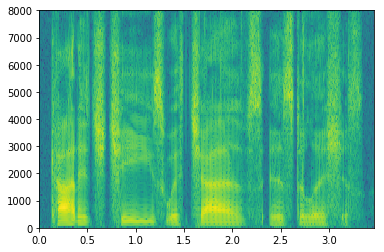

In [78]:
plt.specgram(audio, 256, sample_rate)

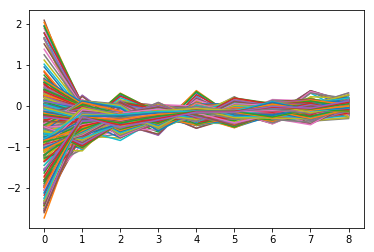

In [79]:
plt.plot(cepstra)

In [70]:
cepstra.shape

(9, 345)

In [80]:
cepstra2.shape

(9, 346)

In [83]:
sum(sum(cepstra))

-691.3944519022496

In [82]:
sum(sum(cepstra2))

-694.1841313452123

In [3]:
from shennong.features.processor.rastaplp import RastaPlpProcessor
audio = Audio.load('./sm1_cln.wav')
processor = RastaPlpProcessor(order=8)
features = processor.process(audio)
features.shape

ModuleNotFoundError: No module named 'shennong.features'